In this notebook, we are going to prepare the data to be used in future models.

In [1]:
import numpy as np                       
import xarray as xr                      
import pandas as pd     
import cftime           
import zipfile       
from datetime import datetime, timedelta
import os
import sys

# Temperature

## Prepare the training data

In [3]:
reanalysis_nc = xr.open_dataset('../Archivos_reanalisisERA5_realesINUMET/Reanalisis/Datos_t2m_horario_2000a2010_uy.nc')
reanalysis_nc_2 = xr.open_dataset('../Archivos_reanalisisERA5_realesINUMET/Reanalisis/Datos_t2m_horario_2011a2021_uy.nc')

def transform_reanalysis(data_nc):
    reanalysis = pd.DataFrame()
    reanalysis['time'] = pd.to_datetime(data_nc.time)
    reanalysis['tas'] = data_nc.t2m.mean(dim=["latitude","longitude"]) 
    reanalysis = reanalysis.loc[reanalysis["time"] < datetime.fromisoformat('2015-01-01T00:00:00')]
    reanalysis['date'] = reanalysis['time'].dt.date
    reanalysis['day'] = reanalysis['time'].dt.day
    reanalysis['month'] = reanalysis['time'].dt.month
    reanalysis_by_day = reanalysis[["date", "tas"]].groupby('date') \
                                                   .mean() \
                                                   .rename(columns={"tas":"tas_daily"})
    reanalysis = reanalysis.join(reanalysis_by_day, on="date") \
                            .drop('date', axis=1)
    return reanalysis

reanalysis = pd.concat([transform_reanalysis(reanalysis_nc), transform_reanalysis(reanalysis_nc_2)])
reanalysis = reanalysis[((reanalysis['day'] != 29) | (reanalysis['month'] != 2))] #Delete all Feb 29th 
reanalysis = reanalysis[['time', 'tas_daily', 'tas']] #select the variables we want to keep
reanalysis.to_csv('reanalysis_tas_training_data.csv',  index=False)

## Prepare the data to be downscaled

In [4]:
CESM2_WACCM_nc = xr.open_dataset('../data/tas_day_CESM2-WACCM_historical_r1i1p1f1_gn_20000101-20141231_v20190227.nc')
CESM2_WACCM = pd.DataFrame()
CESM2_WACCM['time'] = CESM2_WACCM_nc.time
CESM2_WACCM['CESM2_WACCM'] = CESM2_WACCM_nc.tas.mean(dim=["lat","lon"])
CESM2_WACCM['time'] = CESM2_WACCM['time'].apply(lambda x: datetime.fromisoformat(x.isoformat()))

CESM2_WACCM_by_hour = []

for row in CESM2_WACCM.values:
    for h in range(0,24):
        new_row = pd.Series({
            'time': row[0] + timedelta(hours=h),
            'tas': 0,
            'tas_daily': row[1]
        })
        CESM2_WACCM_by_hour.append(new_row)

CESM2_WACCM = pd.DataFrame(CESM2_WACCM_by_hour)
CESM2_WACCM.to_csv('cmip6_tas_to_downscale_data.csv', index=False)

# Wind Speed

## Prepare the training data

**Note**: I've assumed that sfcwind = sqrt(u^2 + v^2). Corroboration is needed.

In [12]:
reanalysis_wind_U_nc = xr.open_dataset('../Archivos_reanalisisERA5_realesINUMET/Reanalisis/Datos_U10m_horario_2000a2010_uy.nc')
reanalysis_wind_V_nc = xr.open_dataset('../Archivos_reanalisisERA5_realesINUMET/Reanalisis/Datos_V10m_horario_2000a2010_uy.nc')
reanalysis_wind_U_2_nc = xr.open_dataset('../Archivos_reanalisisERA5_realesINUMET/Reanalisis/Datos_U10m_horario_2011a2021_uy.nc')
reanalysis_wind_V_2_nc = xr.open_dataset('../Archivos_reanalisisERA5_realesINUMET/Reanalisis/Datos_V10m_horario_2011a2021_uy.nc')


def transform_reanalysis_wind(U_nc, V_nc):
    reanalysis = pd.DataFrame()
    reanalysis['time'] = pd.to_datetime(U_nc.time)
    reanalysis['sfcWind'] = np.sqrt(np.square(U_nc.u10) + np.square(V_nc.v10)) \
                               .mean(dim=["latitude","longitude"]) 
    reanalysis = reanalysis.loc[reanalysis["time"] < datetime.fromisoformat('2015-01-01T00:00:00')]
    reanalysis['date'] = reanalysis['time'].dt.date
    reanalysis['day'] = reanalysis['time'].dt.day
    reanalysis['month'] = reanalysis['time'].dt.month
    reanalysis_by_day = reanalysis[["date", "sfcWind"]].groupby('date') \
                                                   .mean() \
                                                   .rename(columns={"sfcWind":"sfcWind_daily"})
    reanalysis = reanalysis.join(reanalysis_by_day, on="date") \
                            .drop('date', axis=1)
    return reanalysis

reanalysis_wind = pd.concat([transform_reanalysis_wind(reanalysis_wind_U_nc, reanalysis_wind_V_nc), 
                             transform_reanalysis_wind(reanalysis_wind_U_2_nc, reanalysis_wind_V_2_nc)])

reanalysis_wind = reanalysis_wind[((reanalysis_wind['day'] != 29) | (reanalysis_wind['month'] != 2))] #Delete all Feb 29th 
reanalysis_wind = reanalysis_wind[['time', 'sfcWind_daily', 'sfcWind']] #select the variables we want to keep
reanalysis_wind.to_csv('reanalysis_sfcWind_training_data.csv',  index=False)

## Prepare the data to be downscaled

In [ ]:
CESM2_WACCM_wind_nc = xr.open_dataset('../data/sfcWind_day_CESM2-WACCM_historical_r1i1p1f1_gn_20000101-20141231_v20190227.nc')
CESM2_WACCM_wind = pd.DataFrame()
CESM2_WACCM_wind['time'] = CESM2_WACCM_wind_nc.time
CESM2_WACCM_wind['CESM2_WACCM'] = CESM2_WACCM_wind_nc.sfcWind.mean(dim=["lat","lon"])
CESM2_WACCM_wind['time'] = CESM2_WACCM_wind['time'].apply(lambda x: datetime.fromisoformat(x.isoformat()))

CESM2_WACCM_wind_by_hour = []

for row in CESM2_WACCM_wind.values:
    for h in range(0,24):
        new_row = pd.Series({
            'time': row[0] + timedelta(hours=h),
            'sfcWind': 0,
            'sfcWind_daily': row[1]
        })
        CESM2_WACCM_wind_by_hour.append(new_row)

CESM2_WACCM_wind = pd.DataFrame(CESM2_WACCM_wind_by_hour)
CESM2_WACCM_wind.to_csv('cmip6_sfcWind_to_downscale_data.csv', index=False)
#CESM2_WACCM_wind.head()

# Precipitation

In [25]:
PRECIPTITATION_FOLDER = "../Archivos_reanalisisERA5_realesINUMET/Reanalisis-precipitation/"

def transform_reanalysis(data_nc):
    reanalysis = pd.DataFrame()
    reanalysis['time'] = pd.to_datetime(data_nc.time)
    reanalysis['pr'] = data_nc.tp.sum(dim=["latitude","longitude"])
 #   reanalysis = reanalysis.loc[reanalysis["time"] < datetime.fromisoformat('2015-01-01T00:00:00')]
    reanalysis['date'] = reanalysis['time'].dt.date
    reanalysis['day'] = reanalysis['time'].dt.day
    reanalysis['month'] = reanalysis['time'].dt.month
    reanalysis_by_day = reanalysis[["date", "pr"]].groupby('date') \
                                                   .sum() \
                                                   .rename(columns={"pr":"pr_daily"})
    reanalysis = reanalysis.join(reanalysis_by_day, on="date") \
                            .drop('date', axis=1)
    return reanalysis

reanalysis = pd.DataFrame()

for file in os.listdir(PRECIPTITATION_FOLDER):

    with zipfile.ZipFile(PRECIPTITATION_FOLDER + file,"r") as zip_ref:
        zip_ref.extractall(PRECIPTITATION_FOLDER + "data")
    
    precipitation_nc = xr.open_dataset(PRECIPTITATION_FOLDER + "data/data.nc")
    reanalysis = pd.concat([reanalysis,transform_reanalysis(precipitation_nc)])
    os.remove(PRECIPTITATION_FOLDER + "data/data.nc")
    os.removedirs(PRECIPTITATION_FOLDER + "data")

reanalysis.sort_values(by='time', inplace=True)
reanalysis.reset_index(drop=True, inplace=True)

reanalysis_temp = reanalysis[['time', 'pr_daily', 'pr']]
reanalysis_temp.to_csv('reanalysis_precipitation.csv',  index=False)

reanalysis = reanalysis[((reanalysis['day'] != 29) | (reanalysis['month'] != 2))] #Delete all Feb 29th 
reanalysis = reanalysis[['time', 'pr_daily', 'pr']] #select the variables we want to keep
reanalysis = reanalysis.loc[reanalysis["time"] < datetime.fromisoformat('2015-01-01T00:00:00')]
reanalysis.to_csv('reanalysis_precipitation_training_data.csv',  index=False)

## Prepare the data to be downscaled

In [27]:
CESM2_WACCM_precipitation_nc = xr.open_dataset('../data/pr_day_CESM2-WACCM_historical_r1i1p1f1_gn_20000101-20141231_v20190415.nc')
CESM2_WACCM_precipitation = pd.DataFrame()
CESM2_WACCM_precipitation['time'] = CESM2_WACCM_precipitation_nc.time
CESM2_WACCM_precipitation['CESM2_WACCM'] = CESM2_WACCM_precipitation_nc.pr.sum(dim=["lat","lon"])*3600*24
CESM2_WACCM_precipitation['time'] = CESM2_WACCM_precipitation['time'].apply(lambda x: datetime.fromisoformat(x.isoformat()))

CESM2_WACCM_precipitation_by_hour = []

for row in CESM2_WACCM_precipitation.values:
    for h in range(0,24):
        new_row = pd.Series({
            'time': row[0] + timedelta(hours=h),
            'pr': 0,
            'pr_daily': row[1]
        })
        CESM2_WACCM_precipitation_by_hour.append(new_row)

CESM2_WACCM_precipitation = pd.DataFrame(CESM2_WACCM_precipitation_by_hour)
CESM2_WACCM_precipitation.to_csv('cmip6_precipitation_to_downscale_data.csv', index=False)
#CESM2_WACCM_wind.head()

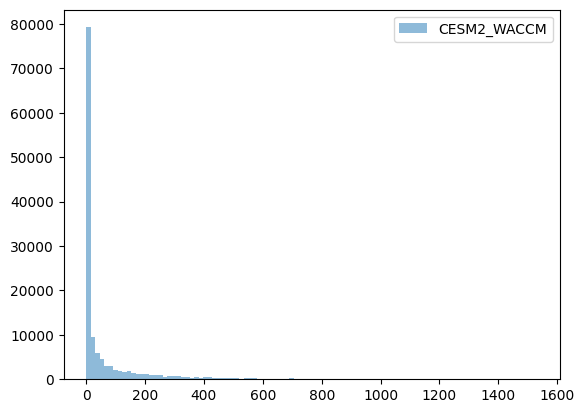

In [33]:
#plot an histogram of the pr column of the cesm2_waccm_precipitation dataframe and one of the reanalysis dataframe
import matplotlib.pyplot as plt
plt.hist(CESM2_WACCM_precipitation['pr_daily'], bins=100, alpha=0.5, label='CESM2_WACCM')
plt.hist(reanalysis['pr_daily'], bins=100, alpha=0.5, label='Reanalysis')
plt.legend(loc='upper right')
plt.show()
